In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd

In [2]:
# load data
data = pd.read_csv('drive/MyDrive/fer2013.csv')

In [3]:
data['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [4]:
train = data[data['Usage']=='Training'].drop('Usage', axis=1)
public_test = data[data['Usage']=='PublicTest'].drop('Usage', axis=1)
private_test = data[data['Usage']=='PrivateTest'].drop('Usage', axis=1)

In [5]:
y_train = train['emotion']
X_train = train['pixels']
y_val = public_test['emotion']
X_val = public_test['pixels']
y_test = private_test['emotion']
X_test = private_test['pixels']

In [6]:
X_train = X_train.apply(lambda s: np.array(list(map(int, s.split(' ')))))
X_val = X_val.apply(lambda s: np.array(list(map(int, s.split(' ')))))
X_test = X_test.apply(lambda s: np.array(list(map(int, s.split(' ')))))

In [7]:
X_train

0        [70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...
1        [151, 150, 147, 155, 148, 133, 111, 140, 170, ...
2        [231, 212, 156, 164, 174, 138, 161, 173, 182, ...
3        [24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...
4        [4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...
                               ...                        
28704    [84, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 8...
28705    [114, 112, 113, 113, 111, 111, 112, 113, 115, ...
28706    [74, 81, 87, 89, 95, 100, 98, 93, 105, 120, 12...
28707    [222, 227, 203, 90, 86, 90, 84, 77, 94, 87, 99...
28708    [195, 199, 205, 206, 205, 203, 206, 209, 208, ...
Name: pixels, Length: 28709, dtype: object

In [8]:
X_train = np.stack(X_train)
X_val = np.stack(X_val)
X_test = np.stack(X_test)

In [9]:
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

In [10]:
scaler = np.vectorize(lambda x: x / 255.0)

In [11]:
X_train = scaler(X_train)
X_val = scaler(X_val)
X_test = scaler(X_test)

In [12]:
X_train = X_train.reshape((X_train.shape[0], 48, 48, 1))
X_test = X_test.reshape((X_test.shape[0], 48, 48, 1))
X_val = X_val.reshape((X_val.shape[0], 48, 48, 1))

In [13]:
# VGG Net: CCP CCP CCP CCP FF
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(64, kernel_size=3, use_bias=False, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(64, kernel_size=3, use_bias=False, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(128, kernel_size=5, use_bias=False, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(128, kernel_size=5, use_bias=False, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(256, kernel_size=3, use_bias=False, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(256, kernel_size=3, use_bias=False, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(512, kernel_size=3, use_bias=False, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(512, kernel_size=3, use_bias=False, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))


model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Dense(7))
model.add(tf.keras.layers.Softmax())


In [14]:
#opt = tf.keras.optimizers.SGD(nesterov=True)
opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=3, min_lr=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_val, y_val), shuffle=True, verbose=1, callbacks=[reduce_lr])

Epoch 1/20
449/449 [==============================] - 66s 117ms/step - loss: 1.8501 - accuracy: 0.2638 - val_loss: 1.9513 - val_accuracy: 0.2494 - lr: 0.0010
Epoch 2/20
449/449 [==============================] - 51s 113ms/step - loss: 1.4904 - accuracy: 0.4165 - val_loss: 1.4288 - val_accuracy: 0.4310 - lr: 0.0010
Epoch 3/20
449/449 [==============================] - 51s 114ms/step - loss: 1.2743 - accuracy: 0.5118 - val_loss: 1.2917 - val_accuracy: 0.5065 - lr: 0.0010
Epoch 4/20
449/449 [==============================] - 51s 114ms/step - loss: 1.1661 - accuracy: 0.5589 - val_loss: 1.2378 - val_accuracy: 0.5316 - lr: 0.0010
Epoch 5/20
449/449 [==============================] - 51s 114ms/step - loss: 1.1012 - accuracy: 0.5845 - val_loss: 1.1665 - val_accuracy: 0.5514 - lr: 0.0010
Epoch 6/20
449/449 [==============================] - 51s 114ms/step - loss: 1.0546 - accuracy: 0.6035 - val_loss: 1.2265 - val_accuracy: 0.5386 - lr: 0.0010
Epoch 7/20
449/449 [==============================] 

In [16]:
model.evaluate(X_val, y_val)

113/113 [==============================] - 3s 20ms/step - loss: 1.1119 - accuracy: 0.6230


[1.1118512153625488, 0.6230147480964661]

In [17]:
import matplotlib.pyplot as plt

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


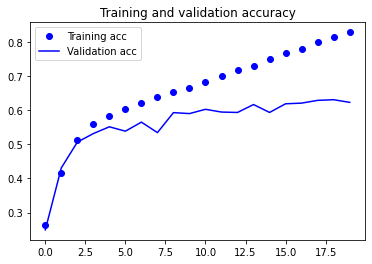

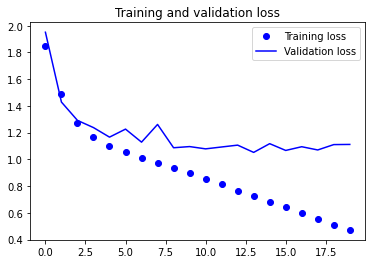

In [19]:

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets
